# Golf Example: Binomial Logistic Regression

This example is shamelessly adopted from the book "[Regression and Other Stories](https://avehtari.github.io/ROS-Examples/)" by Gelman, Hill and Vehtari. This book is freely accessible from this website and is a great resource and introduction to regression modelling.

## Load Required Libraries:

In [125]:
library(ggplot2)
library(rjags)
library(coda)
library(ggmcmc)
library(reshape2)

## Load in Data and Visualise it:

The ``.txt`` file is located in ``data`` subdirectory:

In [71]:
golf_data <- read.table("data/golf.txt", header = TRUE, skip = 2)
head(golf_data, 5)

,x,n,y
,<int>,<int>,<int>
1,2,1443,1346
2,3,694,577
3,4,455,337
4,5,353,208
5,6,272,149


Each row corresponds to the number of attempts at putting and successes for different distances from the hole. The first column ``x`` is the distance in feet from the hole, the second column ``n`` corresponds to the total number of golf putts recorded at the distance ``x`` and the final column ``y`` corresponds to the total number of successful golf putts.

Suppose we are interested of modelling the probability of performing a successful putt as a function of the distance. We would naturally expect that as the distance in feet increases, the probability of success decreases. 

Let's plot the estimated probabilities as a function of distance ``x``.

In [225]:
probability_of_success <- golf_data$y / golf_data$n

golf_df <- cbind(golf_data, probability_of_success)
head(golf_df, 5)

,x,n,y,probability_of_success
,<int>,<int>,<int>,<dbl>
1,2,1443,1346,0.9327789
2,3,694,577,0.8314121
3,4,455,337,0.7406593
4,5,353,208,0.5892351
5,6,272,149,0.5477941


Let's visualise this:

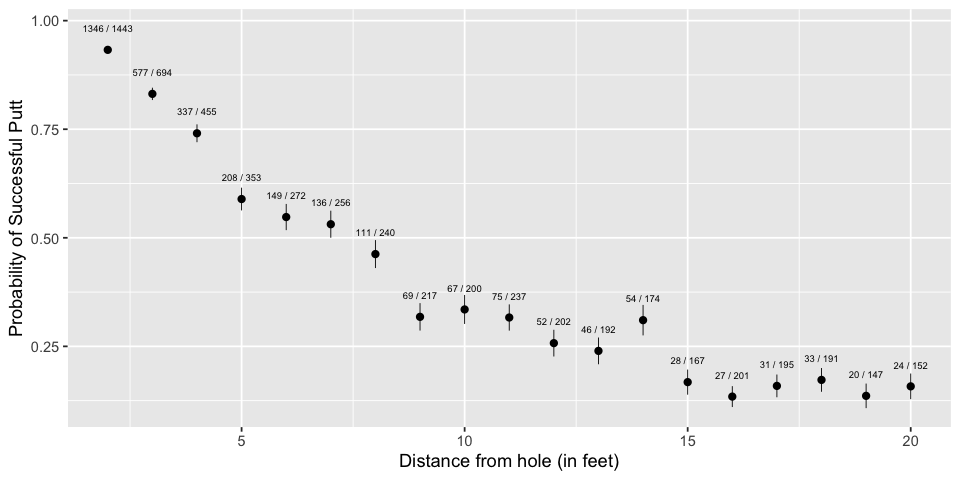

In [226]:
options(repr.plot.width = 8, repr.plot.height = 4)

sd <- sqrt(golf_df$probability_of_success * (1 - golf_df$probability_of_success) / golf_df$n) # binomial standard deviation

golf_data_plot <- ggplot(golf_df) +
                    geom_text(aes(x = x, y = probability_of_success),
                              label = paste(golf_df$y, "/", golf_df$n),
                              nudge_y = 0.05, size = 2, check_overlap = T) +
                    geom_pointrange(aes(x = x, y = probability_of_success,
                                        ymin = probability_of_success - sd,
                                        ymax = probability_of_success + sd),
                                        size = 0.25) +
                    xlab("Distance from hole (in feet)") +
                    ylab("Probability of Successful Putt")

golf_data_plot

## Binomial Regression Model

At each distance $x$ (predictor variable) we observe a particular number of successful putts (response variable) out a particular number of putting attempts. Assuming independence of each golf putt (which seems very plausible), the appropriate probability model for the response variable (the number of successful putts) is Binomial:

$$ Y_i | p_i, n_i \sim \text{Binomial}(n_i, p_i). $$

Here, $n_i$ is the total number of putting attempts for response $i$ and $p_i$ is the probability of success. We are interested in modelling how the probability of success changes as the distance $x$ from the hole changes. Given that we have learnt about logistic regression, a natural model would be:

$$ p_i = \text{Logistic}(a + bx_i), $$

where $x_i$ is the distance (in feet) from the hole for response $i$ and

$$ \text{Logistic}(x) = \frac{1}{1 + \exp(-x)}. $$

The logistic function is used to ensure that $p_i$ is a valid probability and the parameters $a$ and $b$ are to be inferred from the data.

The full model is then:

$$ Y_i | x_i, n_i, a, b \sim \text{Binomial}(n_i, \text{Logistic}(a + bx_i)). $$

The next step is to infer the parameters $a$ and $b$ using Bayesian inference. A non-informative prior of $a \sim \mathcal{N}(0, 1/10)$ and $b \sim \mathcal{N}(0, 1/10)$ seems reasonable.

#### ``JAGS`` code

Let's write this up as a ``JAGS`` program:

In [229]:
model_string <- "
    model{
        # Probability Model (N is number of data):
        for (i in 1:N) {
            linear[i] <- a + b * x[i]
            prob[i] <- ilogit(linear[i])
            Y[i] ~ dbin(prob[i], n[i])
        }

        # Prior:
        a ~ dnorm(0, 1 / 10)
        b ~ dnorm(0, 1 / 10)
    }
    "

#### Running the Code:

Let's run the ``JAGS`` code:

In [236]:
jags_data <- list(Y = golf_df$y, x = golf_df$x, n = golf_df$n, N = nrow(golf_df))
model <- jags.model(textConnection(model_string), data = jags_data, n.chains = 4)
update(model, n.iter = 10000)
samples <- coda.samples(model = model, variable.names = c("a", "b"), n.iter = 20000, thin = 20)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 2
   Total graph size: 121

Initializing model



### Checking MCMC Output

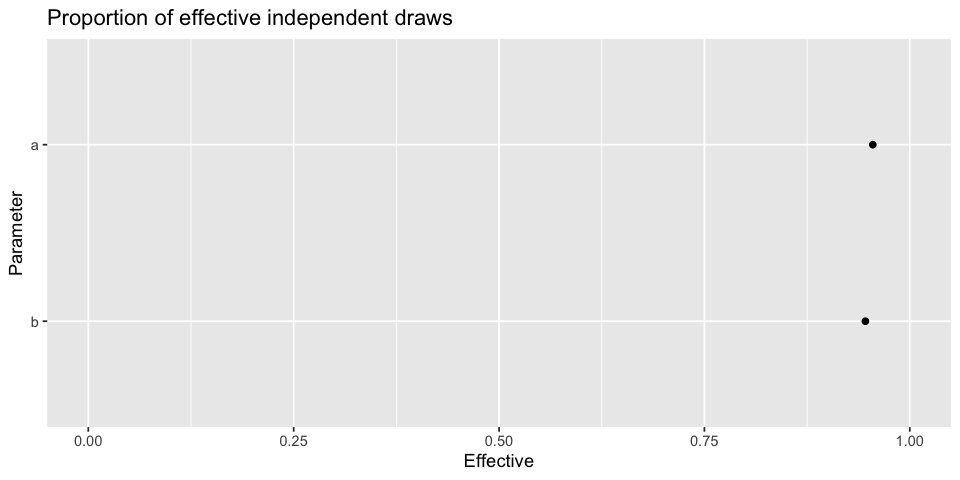

In [237]:
ggs_effective(ggs(samples))

In [238]:
effectiveSize(samples)

a        b 
3842.179 3857.375

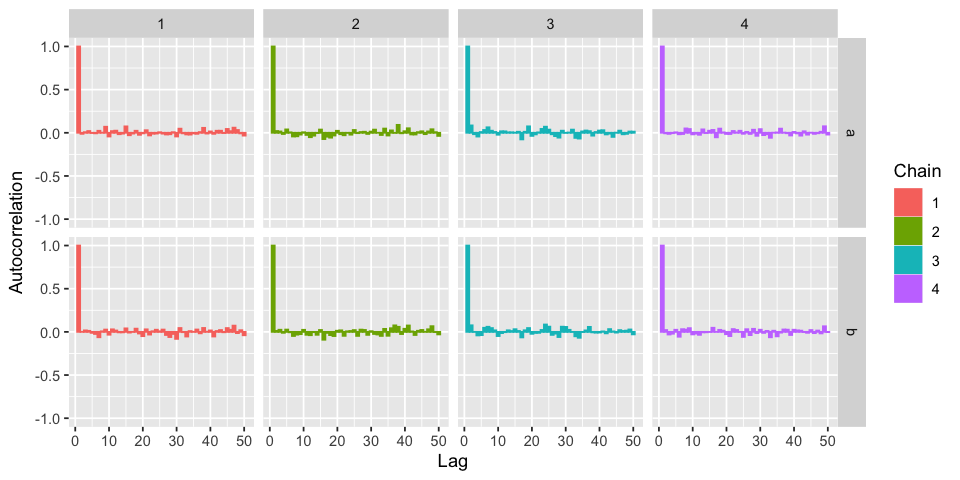

In [239]:
ggs_autocorrelation(ggs(samples))

In [240]:
summary(samples)


Iterations = 11020:31000
Thinning interval = 20 
Number of chains = 4 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean       SD  Naive SE Time-series SE
a  2.2337 0.059517 0.0009411      0.0009624
b -0.2559 0.006767 0.0001070      0.0001092

2. Quantiles for each variable:

     2.5%     25%     50%     75%   97.5%
a  2.1212  2.1920  2.2328  2.2739  2.3519
b -0.2696 -0.2605 -0.2558 -0.2513 -0.2429


### Plotting the fitted model:

We will use the posterior means of each variable ``a`` and ``b`` as our fitted values. We can plot some other curves to demonstrate the variability too:

In [241]:
posterior_mean_vector <- colMeans(as.matrix(samples))
a_mean <- posterior_mean_vector[1]
b_mean <- posterior_mean_vector[2]

#### Plotting the Logistic Curve of the Posterior Mean:

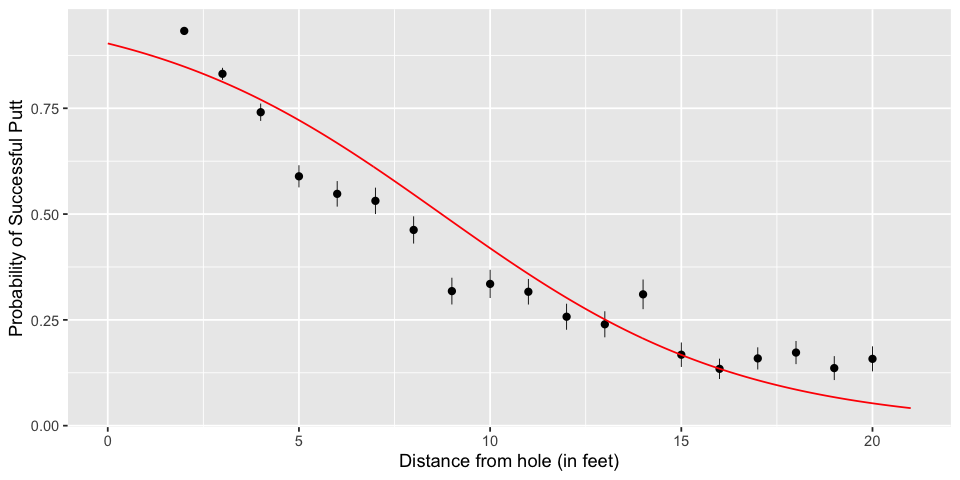

In [242]:
options(repr.plot.width = 8, repr.plot.height = 4)

sd <- sqrt(golf_df$probability_of_success * (1 - golf_df$probability_of_success) / golf_df$n) # binomial standard deviation

x_mesh <- seq(0, 21, length.out = 300)
# the logistic function in R is plogis:
logistic_mesh <- plogis(a_mean + b_mean * x_mesh)

logistic_df <- data.frame(x = x_mesh, y = logistic_mesh)

golf_data_plot <- ggplot(golf_df) +
                    geom_pointrange(aes(x = x, y = probability_of_success,
                                        ymin = probability_of_success - sd,
                                        ymax = probability_of_success + sd),
                                        size = 0.25) +
                    xlab("Distance from hole (in feet)") +
                    ylab("Probability of Successful Putt") +
                    geom_line(data = logistic_df, aes(x = x, y = y), color = "red")

golf_data_plot

#### Plotting the Logistic Curve for Posterior Samples:

This is better because it also gives a visualisation of the posterior uncertainty.

In order to do this, we need to compute evaluations of the logistic function for a bunch of different posterior samples of ``a`` and ``b``. The easiest way to do this is to use an ``apply``. We will plot the logistic curve for $400$ samples from the posterior:

In [244]:
posterior_400_samples <- as.matrix(samples)[1:400, ]
logistic_posterior_evals <- t(apply(posterior_400_samples, 1, function(sample) (plogis(sample[1] + sample[2] * x_mesh))))

Each row of ``logistic_posterior_evals`` corresponds to evaluations of the curve

$$ \text{Logistic}(a + b x) $$

for a posterior sample of ``a`` and ``b`` over ``x_mesh``.

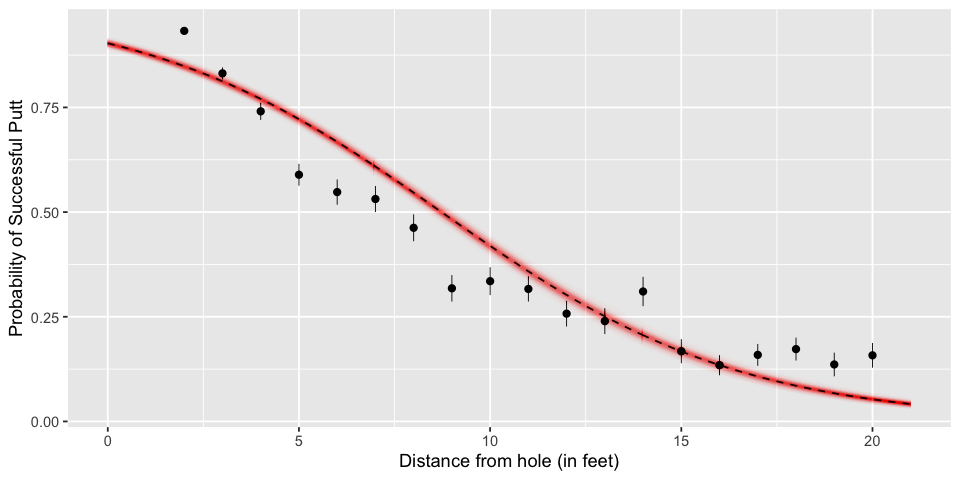

In [245]:
options(repr.plot.width = 8, repr.plot.height = 4)
library(reshape2)

logistic_samples_df <- melt(data.frame(x_mesh, t(logistic_posterior_evals)), id = "x_mesh")

golf_data_plot <- ggplot(golf_df) +
                    geom_pointrange(aes(x = x, y = probability_of_success,
                                        ymin = probability_of_success - sd,
                                        ymax = probability_of_success + sd),
                                        size = 0.25) +
                    xlab("Distance from hole (in feet)") +
                    ylab("Probability of Successful Putt") +
                    geom_line(data = logistic_samples_df, aes(x = x_mesh, y = value, group = variable),
                              color = "red", alpha = 0.002) +
                    geom_line(data = logistic_df, aes(x = x, y = y), color = "#200000",
                              linetype = "dashed")

golf_data_plot

#### Evaluating the Model:

This implies overconfidence!

In [246]:
dic.samples(model, n.iter = 10000, thin = 10)

Mean deviance:  363.9 
penalty 1.971 
Penalized deviance: 365.9 

## Binomial Regression with a Quadratic Term

To increase flexibility, we can introduce a quadratic term as a predictor. That is, we now model the probability $p_i$ of the $i\text{th}$ response as

$$ p_i = \text{Logistic}(a + bx_i + cx_i^2).$$

This is still a linear in the coefficients. The ``JAGS`` code is a simple extension:

In [247]:
model_string <- "
    model{
        # Probability Model (N is number of data):
        for (i in 1:N) {
            linear[i] <- a + b * x[i] + c * x[i] ** 2
            prob[i] <- ilogit(linear[i])
            Y[i] ~ dbin(prob[i], n[i])
        }

        # Prior:
        a ~ dnorm(0, 1 / 10)
        b ~ dnorm(0, 1 / 10)
        c ~ dnorm(0, 1 / 10)
    }
    "

Running the code:

In [248]:
jags_data <- list(Y = golf_df$y, x = golf_df$x, n = golf_df$n, N = nrow(golf_df))
model <- jags.model(textConnection(model_string), data = jags_data, n.chains = 4)
update(model, n.iter = 100000)
samples <- coda.samples(model = model, variable.names = c("a", "b", "c"), n.iter = 100000, thin = 200)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 3
   Total graph size: 161

Initializing model



In [249]:
effectiveSize(samples)

a        b        c 
1885.474 1816.839 1851.085

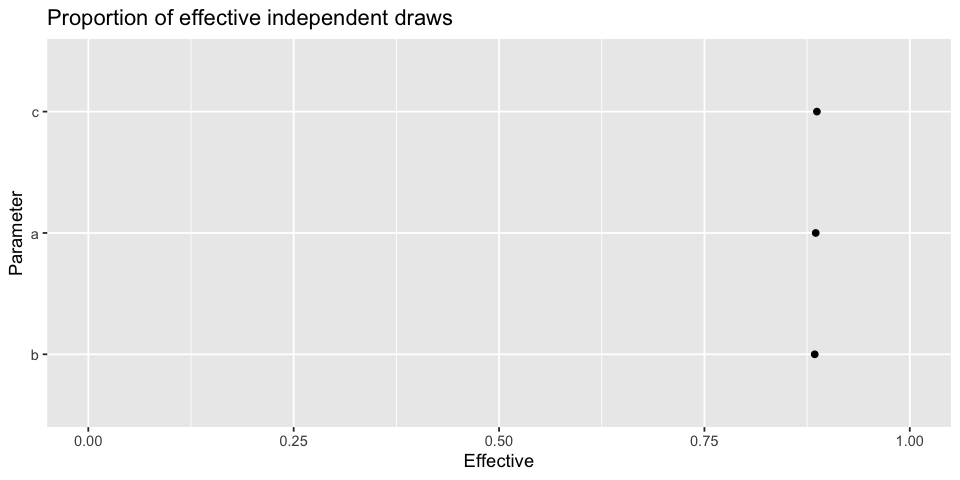

In [250]:
ggs_effective(ggs(samples))

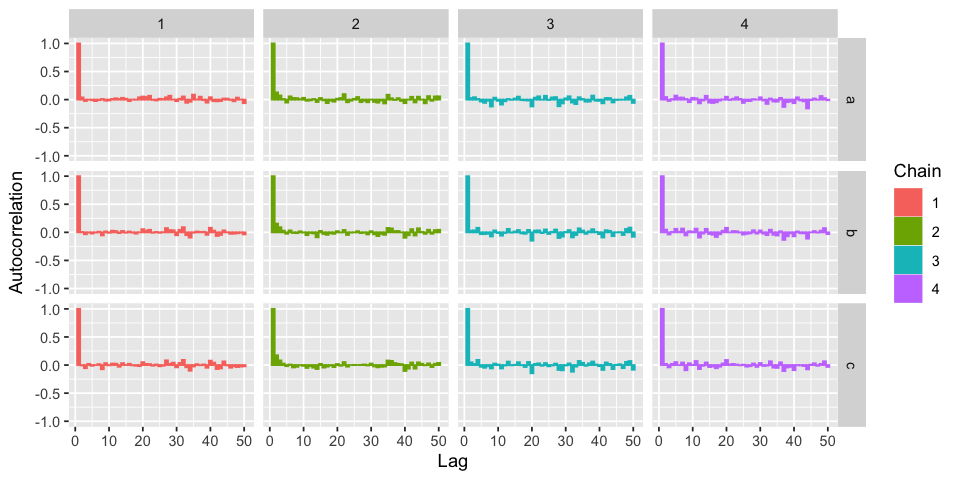

In [251]:
ggs_autocorrelation(ggs(samples))

### Plotting the Fitted Models:

In [252]:
posterior_mean_vector <- colMeans(as.matrix(samples))
a_mean <- posterior_mean_vector[1]
b_mean <- posterior_mean_vector[2]
c_mean <- posterior_mean_vector[3]

#### Plotting the Posterior Mean:

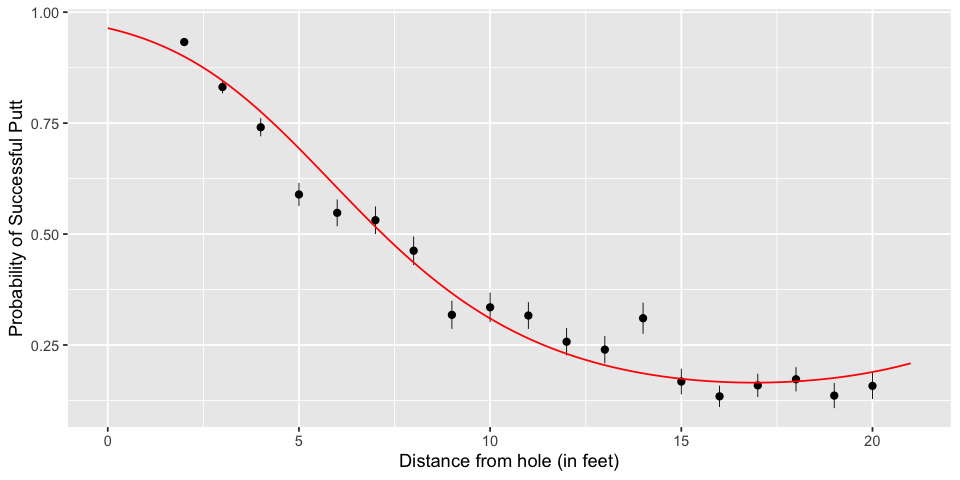

In [253]:
options(repr.plot.width = 8, repr.plot.height = 4)

x_mesh <- seq(0, 21, length.out = 300)
# the logistic function in R is plogis:
logistic_mesh <- plogis(a_mean + b_mean * x_mesh + c_mean * x_mesh ** 2)

logistic_df <- data.frame(x = x_mesh, y = logistic_mesh)

golf_data_plot <- ggplot(golf_df) +
                    geom_pointrange(aes(x = x, y = probability_of_success,
                                        ymin = probability_of_success - sd,
                                        ymax = probability_of_success + sd),
                                        size = 0.25) +
                    xlab("Distance from hole (in feet)") +
                    ylab("Probability of Successful Putt") +
                    geom_line(data = logistic_df, aes(x = x, y = y), color = "red")

golf_data_plot

#### Plotting the Logistic Curve for Posterior Samples:

In [254]:
posterior_400_samples <- as.matrix(samples)[1:400, ]
logistic_posterior_evals <- t(apply(posterior_400_samples, 1, function(sample) (plogis(sample[1] + sample[2] * x_mesh + sample[3] * x_mesh ** 2))))

Let's plot this:

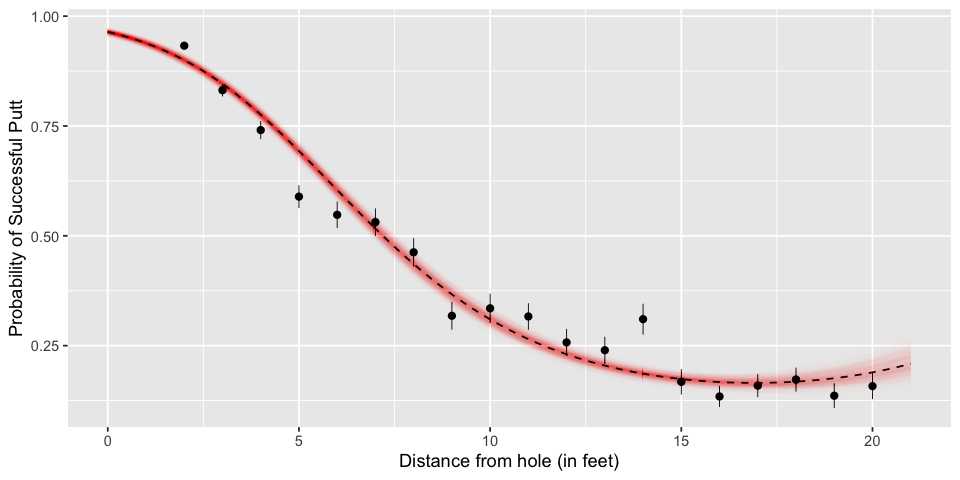

In [255]:
options(repr.plot.width = 8, repr.plot.height = 4)
library(reshape2)

logistic_samples_df <- melt(data.frame(x_mesh, t(logistic_posterior_evals)), id = "x_mesh")

golf_data_plot <- ggplot(golf_df) +
                    geom_pointrange(aes(x = x, y = probability_of_success,
                                        ymin = probability_of_success - sd,
                                        ymax = probability_of_success + sd),
                                        size = 0.25) +
                    xlab("Distance from hole (in feet)") +
                    ylab("Probability of Successful Putt") +
                    geom_line(data = logistic_samples_df, aes(x = x_mesh, y = value, group = variable),
                              color = "red", alpha = 0.002) +
                    geom_line(data = logistic_df, aes(x = x, y = y), color = "#200000",
                              linetype = "dashed")

golf_data_plot

In [256]:
dic.samples(model, n.iter = 10000, thin = 10)

Mean deviance:  182.7 
penalty 2.987 
Penalized deviance: 185.7 

## Modelling from First Principles - Non-Linear Regression

Consider the following plots:

![Golf Putting Plot](figures/golf1.png)

The ball will go in the hole if the angle $\theta$ is sufficiently small. How small? At the time it reaches the hole, it needs to be within a distance of $R-r$ from the centre of the hole ($R$ is radius of hole and $r$ is radius of golf ball). Therefore, at a distance $x$ from the hole and using some trigonometry:

$$ \sin(\theta) = \frac{R-r}{x} $$

Which implies that if the golfer manages an angle $\theta$ that satisfies $$-\arcsin\left(\frac{R-r}{x}\right) \leq \theta \leq \arcsin\left(\frac{R-r}{x}\right),$$ then the ball will go in the hole.

There is a degree of randomness to the variability of the golfers ability to control this angle $\theta$. A normal distribution seems like a suitable model, where

$$ \theta \sim \mathcal{N}(0, \sigma^2), $$

with unknown variance $\sigma^2$. This implies that:

$$ \text{Prob}(\text{Successfful Putt}) = 2\Phi\left(\arcsin\left(\frac{R-r}{x}\right) \sigma^{-1}\right) - 1.$$

Let's use this as our model for the probability of success in the Binomial logistic model:

$$ Y_i | x_i, n_i, a, b \sim \text{Binomial}\left(n_i, 2\Phi\left(\arcsin\left(\frac{R-r}{x_i}\right) \sigma^{-1}\right) - 1\right). $$

We only need to infer one parameter, $\sigma$, since the values of the radius of the hole (in feet) $R = 2.125/2$ and radius of ball (in feet) $r = 0.84/2$ are assumed to be given.

In [257]:
model_string <- "
    model{
        # Probability Model (N is number of data):
        for (i in 1:N) {
            prob[i] <- 2 * phi(arcsin((R - r) / x[i]) / sigma) - 1
            Y[i] ~ dbin(prob[i], n[i])
        }

        r <- (1.68 / 2) / 12
        R <- (4.25 / 2) / 12

        sigma ~ dgamma(1, 1)
    }
    "

In [258]:
jags_data <- list(Y = golf_df$y, x = golf_df$x, n = golf_df$n, N = nrow(golf_df))
model <- jags.model(textConnection(model_string), data = jags_data, n.chains = 4)
update(model, n.iter = 100000)
samples <- coda.samples(model = model, variable.names = c("sigma"), n.iter = 100000, thin = 200)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 1
   Total graph size: 183

Initializing model



### Plotting the fitted model:

In [259]:
summary(samples)


Iterations = 101200:201000
Thinning interval = 200 
Number of chains = 4 
Sample size per chain = 500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     2.665e-02      3.960e-04      8.854e-06      9.049e-06 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.02584 0.02638 0.02665 0.02690 0.02743 


In [183]:
sigma_mean <- mean(as.matrix(samples))

#### Plotting the Posterior Mean:

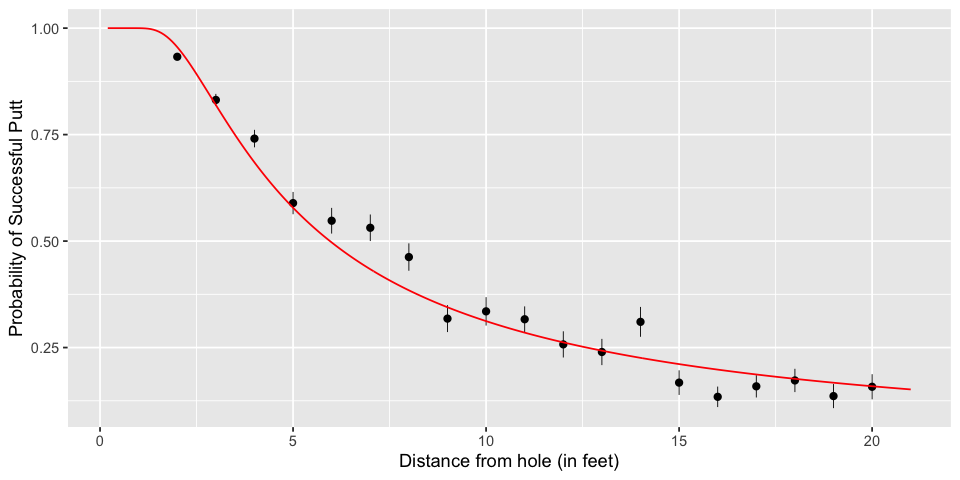

In [260]:
options(repr.plot.width = 8, repr.plot.height = 4)

x_mesh <- seq(0.2, 21, length.out = 300)
r <- (1.68 / 2) / 12
R <- (4.25 / 2) / 12
prob_mesh <- 2 * pnorm(asin((R - r) / x_mesh) / sigma_mean) - 1

prob_df <- data.frame(x = x_mesh, y = prob_mesh)

golf_data_plot <- ggplot(golf_df) +
                    geom_pointrange(aes(x = x, y = probability_of_success,
                                        ymin = probability_of_success - sd,
                                        ymax = probability_of_success + sd),
                                        size = 0.25) +
                    xlab("Distance from hole (in feet)") +
                    ylab("Probability of Successful Putt") +
                    geom_line(data = prob_df, aes(x = x, y = y), color = "red")

golf_data_plot

#### Plotting Posterior Samples:

In [201]:
posterior_400_samples <- as.matrix(samples)[1:400, ]
prob_posterior_samples <- t(sapply(posterior_400_samples, function(sample) (2 * pnorm(asin((R - r) / x_mesh) / sample) - 1)))

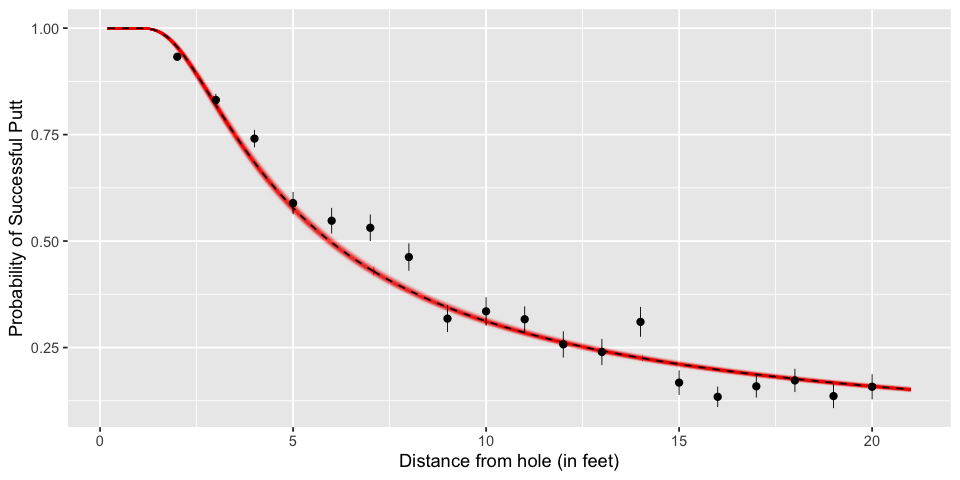

In [202]:
options(repr.plot.width = 8, repr.plot.height = 4)
library(reshape2)

prob_samples_df <- melt(data.frame(x_mesh, t(prob_posterior_samples)), id = "x_mesh")

golf_data_plot <- ggplot(golf_df) +
                    geom_pointrange(aes(x = x, y = probability_of_success,
                                        ymin = probability_of_success - sd,
                                        ymax = probability_of_success + sd),
                                        size = 0.25) +
                    xlab("Distance from hole (in feet)") +
                    ylab("Probability of Successful Putt") +
                    geom_line(data = prob_samples_df, aes(x = x_mesh, y = value, group = variable),
                              color = "red", alpha = 0.002) +
                    geom_line(data = prob_df, aes(x = x, y = y), color = "#200000",
                              linetype = "dashed")

golf_data_plot

In [203]:
dic.samples(model, n.iter = 10000, thin = 10)

Mean deviance:  167.9 
penalty 0.9557 
Penalized deviance: 168.8 

## Plotting Quadratic vs. First Principles Model

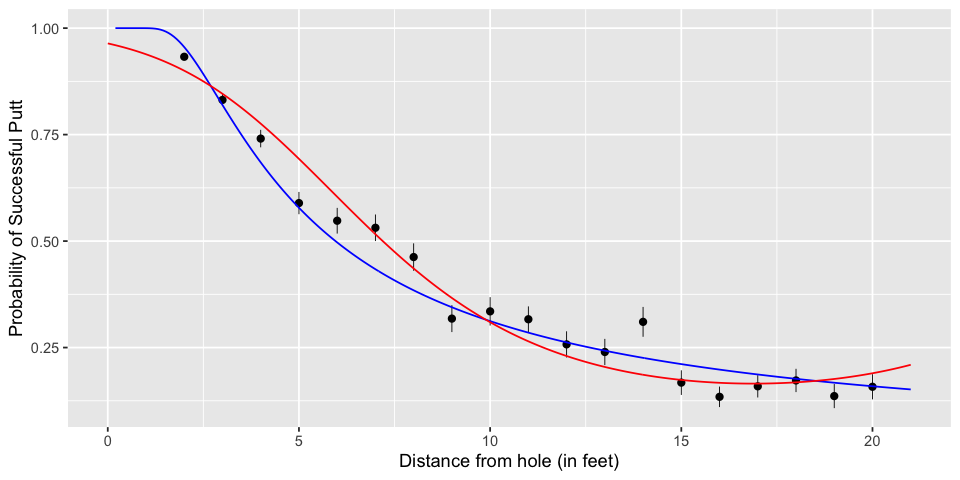

In [223]:
options(repr.plot.width = 8, repr.plot.height = 4)
library(reshape2)

prob_samples_df <- melt(data.frame(x_mesh, t(prob_posterior_samples)), id = "x_mesh")

golf_data_plot <- ggplot(golf_df) +
                    geom_pointrange(aes(x = x, y = probability_of_success,
                                        ymin = probability_of_success - sd,
                                        ymax = probability_of_success + sd),
                                        size = 0.25) +
                    xlab("Distance from hole (in feet)") +
                    ylab("Probability of Successful Putt") +
                    geom_line(data = prob_df, aes(x = x, y = y), color = "blue") +
                    geom_line(data = logistic_df, aes(x = x, y = y), color = "red")

golf_data_plot